# Title

## Setting up the data

First we need to import all the relevant libraries as well as set up the data.

In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from AUS_Functions import *
from shapely.geometry import Polygon, MultiPolygon
import re

In [2]:
sns.set()
colors = {
    "blue": "#4C72B0",
    "orange": "#DD8452",
    "green": "#55A868",
    "red": "#C44E52",
    "grey": "#8C8C8C",
    "black": "#000000"
}


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin

## EDA

Since the three tasks we want to accomplish use different datasets and features in those datasets, I've split the EDA into several parts to cover only the relevant datasets and columns to the task at hand.

Data relevant to our task is split into two datasets - one containing rejected and the other containing accepted loan applications. So before we can properly do EDA, we must combine the datasets together. 

Let's take a look at the rejected data first.

In [53]:
df = pd.read_csv('data/rejected_2007_to_2018Q4.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


The dataset is quite large - there are more than 27 million entries. Taking up 2 GB of RAM, it's more than my computer can easily process. Let's see how best should we go about sampling the dataset.

In [6]:
df.isnull().sum()

Amount Requested               0
Application Date               0
Loan Title                  1303
Risk_Score              18497630
Debt-To-Income Ratio           0
Zip Code                     293
State                         22
Employment Length         951355
Policy Code                  918
dtype: int64

We can see that there are quite a lot of missing values, especially for the "risk_score" feature. A good first step at getting a smaller dataset could be dropping the rows with missing values. However, we need to be careful with doing that - since about 2/3 of the whole dataset has missing values, by dropping them we could heavily alter the natural distributions for the features, especially, if the values are not missing completely at random.

To check, we will compare samples from untouched data and from data with dropped missing values.

In [54]:
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()

df_sample = df.sample(frac = 0.1)
df = df.dropna(axis=0)
df = df.sample(frac = 0.25)

df["dropna"] = 1
df_sample["dropna"] = 0
df = pd.concat([df, df_sample])
df = df.reset_index(drop=True)
del(df_sample)

df.head()

,amount_requested,application_date,loan_title,risk_score,debt_to_income_ratio,zip_code,state,employment_length,policy_code,dropna
0,2500.0,2018-06-16,Other,572.0,0%,183xx,PA,3 years,0.0,1
1,15000.0,2017-10-16,Debt consolidation,624.0,69.61%,748xx,OK,< 1 year,0.0,1
2,5000.0,2017-11-20,Credit card refinancing,653.0,35.8%,076xx,NJ,< 1 year,0.0,1
3,10000.0,2016-11-17,Business,557.0,22.62%,945xx,CA,< 1 year,0.0,1
4,30000.0,2017-07-03,Credit card refinancing,606.0,127.04%,350xx,AL,< 1 year,0.0,1


Differences in distributions for most features were miniscule, except for the "application_date".

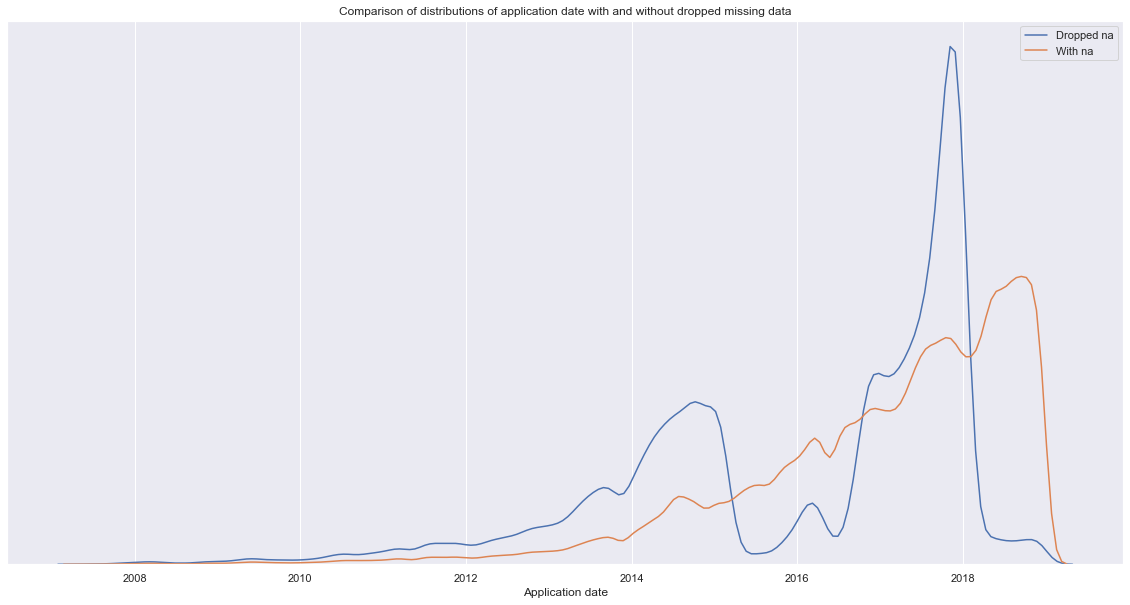

In [56]:
df["application_date"] = pd.to_datetime(df["application_date"])
df["month"] = df["application_date"].dt.month

plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="application_date",
    hue="dropna",
    palette=[colors["orange"], colors["blue"]],
    common_norm=False
)
plt.legend(labels=["Dropped na", "With na"], title="")
ax.set(xlabel="Application date", ylabel="")
ax.set_title("Comparison of distributions of application date with and without dropped missing data")
ax.set_yticks([])

plt.show()

There seems to be a lot of missing data in 2015, 2016 and 2019.

Let's check the difference for the data split by month - one of the most likely ways we might use the application_date feature.

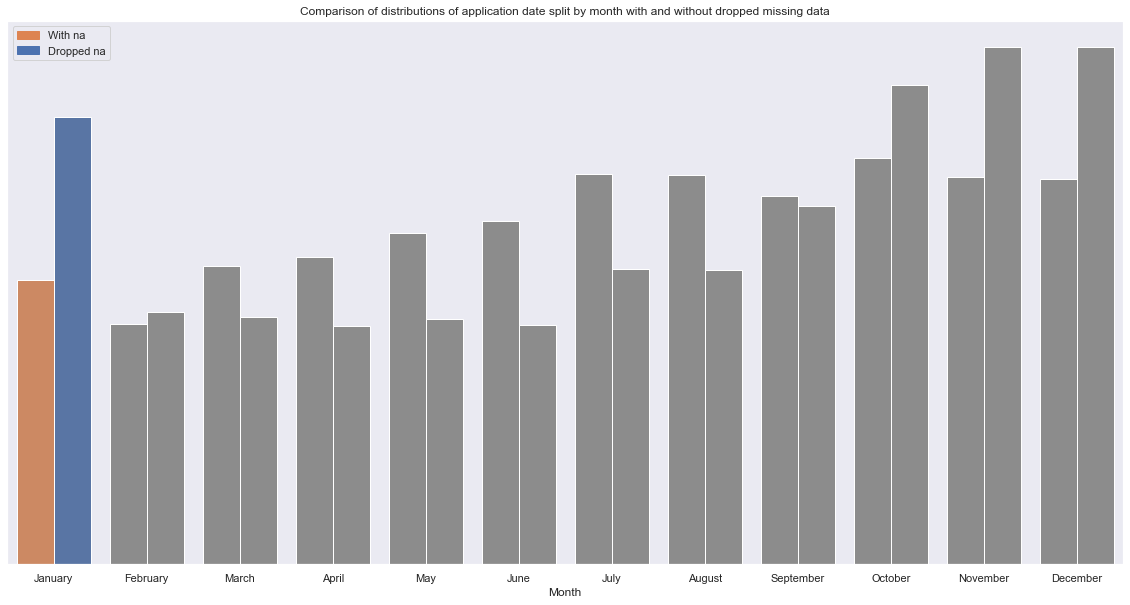

In [58]:
df_month = df.loc[:, ["month", "dropna", "policy_code"]]
df_month.index.name = "id"
months_dict = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
df_month["month"] = df_month["month"].replace(months_dict)
df_month["month"] = pd.Categorical(df_month["month"], categories=list(list(months_dict.values())))

draw_comparison_barplot(df_month, "dropna", "month", ["January"], ["Comparison of distributions of application date split by month with and without dropped missing data", "Month", "", "With na", "Dropped na"], mode="proportion", y_labels=False)

We can see that there is quite a pronounced difference in some months - the most extreme being in January.

Before we proceed let's quickly compare the date and month data between accepted and rejected datasets - to see how important the feature might be for discerning between the two.

In [65]:
df = pd.read_csv('data/rejected_2007_to_2018Q4.csv')
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()
df = df.sample(frac = 0.1)

df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

df["accepted"] = 0
df2["accepted"] = 1
df = df.loc[:, ["application_date", "accepted"]]
df2 = df2.loc[:, ["issue_d", "accepted"]]
df2 = df2.rename(columns={"issue_d":"application_date"})

df = pd.concat([df, df2])
df = df.reset_index(drop=True)

df["application_date"] = pd.to_datetime(df["application_date"])
df = df.dropna(axis=0)
df["month"] = df["application_date"].dt.month
df["month"] = df["month"].replace(months_dict)
df["month"] = pd.Categorical(df["month"], categories=list(list(months_dict.values())))

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_11664\1051733384.py:5: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


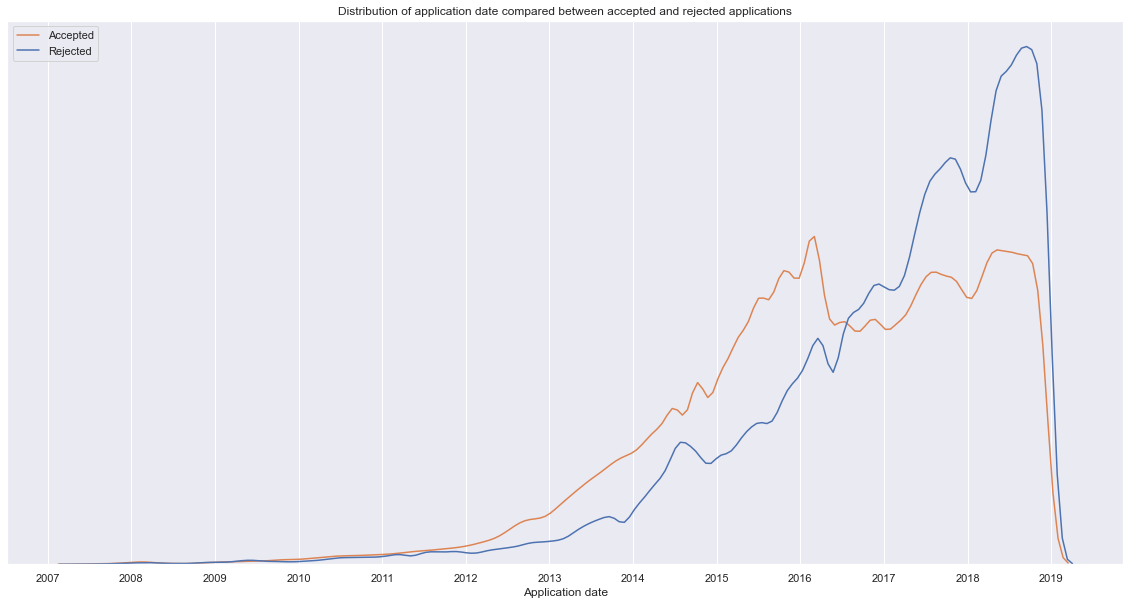

In [74]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="application_date",
    hue="accepted",
    palette=[colors["blue"], colors["orange"]],
    common_norm=False
)
plt.legend(labels=["Accepted", "Rejected"], title="")
ax.set(xlabel="Application date", ylabel="")
ax.set_xticks(pd.to_datetime([str(2007 + x) for x in range(13)]))
ax.set_xticklabels([2007 + x for x in range(13)])
ax.set_title("Distribution of application date compared between accepted and rejected applications")
ax.set_yticks([])

plt.show()

We can see that something must have happened to the market in 2016 (perhaps the (stock market crash due to Brexit?)[https://en.wikipedia.org/wiki/2015%E2%80%932016_stock_market_selloff#:~:text=The%20vote%20led%20to%20stock,dollars%20by%20June%2027%2C%202016.] ) that made applications a lot less likely to be accepted - while the number of rejected applications has continued to grow, the amount of accepted applications hadn't recovered yet in the 2019. Excluding that the distributions seem quite alike.

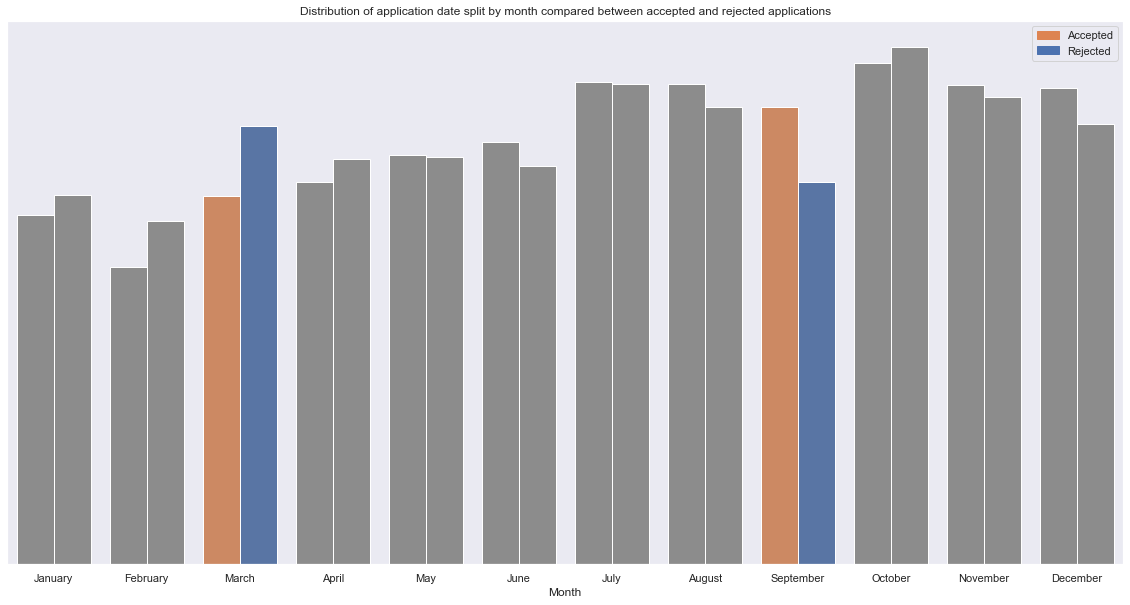

In [72]:
df.index.name = "id"
draw_comparison_barplot(df, "accepted", "month", ["March", "September"], ["Distribution of application date split by month compared between accepted and rejected applications", "Month", "", "Accepted", "Rejected"], mode="proportion", y_labels=False)

If we look at the difference of distributions between months, there seem to be several that contain different proportion compared to the other distribution. However, if we look at the previous graph, we can attribute the unequal proportions in March to the 2016 crash event. For September a single event is harder to spot, however, there also doesn't seem to be an obvious yearly pattern for it. 

Overall, it seems like date and month data is not that important for the task and we can drop the column and all the rows with missing values. I think that the data we get will be better - since we won't have any missing data to impute and all the entries will contain actual data.

In [4]:
def df2_to_df(df2):
    df2 = df2.loc[:, ["loan_amnt", "title", "fico_range_low", "fico_range_high", "dti", "zip_code", "addr_state", "emp_length", "loan_status"]]
    df2["risk_score"] = (df2["fico_range_low"] + df2["fico_range_high"])/2
    df2["accepted"] = 1
    df2.loc[df2["loan_status"] == "Charged Off","accepted"] = 2
    df2 = df2.drop(["fico_range_low", "fico_range_high", "loan_status"], axis=1)
    
    df2_name_dict = {
        "loan_amnt":"amount_requested",
        "title":"loan_title",
        "dti":"debt_to_income_ratio",
        "addr_state":"state",
        "emp_length":"employment_length"
    }
    df2 = df2.rename(columns=df2_name_dict)
    return df2

In [5]:
def clean_data(df):
    df["employment_length"] = df["employment_length"].replace({"10+ years":"15", "< 1 year":"0"})
    df["employment_length"] = df["employment_length"].str.extract(r"([0-9]+)").astype("float")
    df = df.rename(columns={"employment_length" : "employment_length_years"})
    df["debt_to_income_ratio"] = df["debt_to_income_ratio"].replace("%", "", regex=True).astype(float)
    df["amount_requested"] = df["amount_requested"].astype(int)
    
    df.loc[:, "loan_title"] = df["loan_title"].str.lower().replace("[^a-zA-Z0-9]", " ", regex=True)

    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

    return df

In [6]:
def zip_state_to_coordinates(df):
    df = df.drop(df[df["zip_code"].isnull()].index.tolist(), axis=0)
    df["bin"] = df["zip_code"].str.strip("x") + df["state"]
    df = df.merge(bin_coord_means.reset_index(), on="bin", how="left")
    df = df.merge(state_coord_means.reset_index(), on="state", how="left")
    df["latitude"] = df["latitude"].fillna(df["state_latitude"])
    df["longitude"] = df["longitude"].fillna(df["state_longitude"])
    df.drop(["zip_code", "bin"], axis=1, inplace=True)
    
    return df

In [21]:
def lower_data_size_1st_model(df):
    df["application_date"] = pd.to_datetime(df["application_date"])
    
    df["employment_length"] = df["employment_length"].replace({"10+ years":"15", "< 1 year":"0"})
    df["employment_length"] = df["employment_length"].str.extract(r"([0-9]+)").astype("int")
    df.rename(columns={"employment_length" : "employment_length_years"})
    
    df["debt_to_income_ratio"] = df["debt_to_income_ratio"].replace("%", "", regex=True).astype(float)
    
    int_list = object_to_int_list + ["amount_requested", "risk_score", "policy_code", "employment_length_years"]
    df["debt_to_income_ratio"] = df["debt_to_income_ratio"].apply(pd.to_numeric, downcast='float')
    df[int_list] = df[int_list].apply(pd.to_numeric, downcast='integer')
    
    return df

In [7]:
df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')
df2 = df2_to_df(df2)
df2.shape[0]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_7772\522979848.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


2260701

Dataset containing accepted data has a lot of columns that are not relevant to us and the column names are different than for the rejected data, so we use a custom function that filters out the data that we need and renames the columns.

We can see that accepted dataset has only 2 million entries - a lot less than the rejected dataset even after we've excluded the missing data. To balance out the datasets and make the complete size manageable, we will be sampling the accepted dataset to approximately the same size as the rejected dataset.

In [8]:
df = pd.read_csv('data/rejected_2007_to_2018Q4.csv')
df = df.dropna(axis=0)
df = df.sample(frac = 0.25)
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()

df["accepted"] = 0
df = df.drop(["policy_code", "application_date"], axis=1)

We also have to drop the "policy code" feature - the feature is related to the action taken ("accepted", "rejected") and thus contains information unknown to us at the moment of prediction.

In [9]:
df2.isnull().sum()

amount_requested            33
loan_title               23358
debt_to_income_ratio      1744
zip_code                    34
state                       33
employment_length       146940
risk_score                  33
accepted                     0
dtype: int64

We dropped all the missing entries in the rejected dataset, but there are some in the accepted dataset that we will have to deal with.

In [10]:
df2 = df2.drop(df2[df2["amount_requested"].isnull()].index, axis=0)

df = pd.concat([df, df2])
df = df.reset_index(drop=True)

del(df2)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4508717 entries, 0 to 4508716
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   amount_requested      float64
 1   loan_title            object 
 2   risk_score            float64
 3   debt_to_income_ratio  object 
 4   zip_code              object 
 5   state                 object 
 6   employment_length     object 
 7   accepted              int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 275.2+ MB


After combining both the accepted data and the sample from rejected dataset, we get 4.5 million entries. Memory usage is still high due to most of the features having been designated as containing strings, but hopefully with some data cleaning and engineering we'll be able to bring it down.

In [11]:
df.head()

,amount_requested,loan_title,risk_score,debt_to_income_ratio,zip_code,state,employment_length,accepted
0,20000.0,debt_consolidation,632.0,48.54%,243xx,VA,< 1 year,0
1,20000.0,Debt consolidation,673.0,76.25%,432xx,OH,< 1 year,0
2,1000.0,Debt consolidation,631.0,0%,276xx,NC,1 year,0
3,1000.0,moving,569.0,128.66%,547xx,WI,< 1 year,0
4,1800.0,debt_consolidation,531.0,4%,476xx,IN,< 1 year,0


We can see that some of the string columns actually contain numeric data - debt_to_income_ratio column contains percentages, while employement_length contains discrete numeric data. We will use a custom function to transform the features to numeric as well as downcast all numeric columns as much as possible to minimize the memory usage of the data. Zip_code also contains numbers, but we will look at it later.

In [12]:
df = clean_data(df)
df_copy = df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4508717 entries, 0 to 4508716
Data columns (total 8 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amount_requested         int32  
 1   loan_title               object 
 2   risk_score               float32
 3   debt_to_income_ratio     float32
 4   zip_code                 object 
 5   state                    object 
 6   employment_length_years  float32
 7   accepted                 int8   
dtypes: float32(3), int32(1), int8(1), object(3)
memory usage: 176.3+ MB


We can see that memory usage is smaller now.

In [13]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,amount_requested,risk_score,debt_to_income_ratio,employment_length_years,accepted
count,4508717.00000,4508717.00000,4507006.00000,4361810.00000,4508717.00000
mean,13843.39351,664.02002,89.50935,4.06340,0.56096
std,10157.07826,77.02917,3986.81006,5.67515,0.60449
min,300.00000,0.00000,-1.00000,0.00000,0.00000
25%,5200.00000,636.00000,10.89000,0.00000,0.00000
50%,10500.00000,675.00000,18.73000,0.00000,1.00000
75%,20000.00000,702.00000,28.43000,6.00000,1.00000
max,1400000.00000,990.00000,3225600.00000,15.00000,2.00000


Some of the features - "amount_requested" and "debt_to_income_ratio" seem to be quite heavily right skewed.

In [50]:
accepted_to_words = {0:"Rejected", 1:"Accepted", 2:"Charged off"}
df["accepted"].value_counts().rename(index=accepted_to_words)

Rejected       2248049
Accepted       1992109
Charged off     268559
Name: accepted, dtype: int64

Our target column - accepted is currently split into 3 values - rejected applications, accepted applications and accepted applications that got charged off. "Charged off" means that the applicator has been negligent to his due payments for long enough that the creditor no longer believes that the debt will be payed and cuts his losses. It might improve our model if we exclude theses failed cases.

Now that we've combined the data and cleaned up the data a bit, let's take a closer look at each of the features.

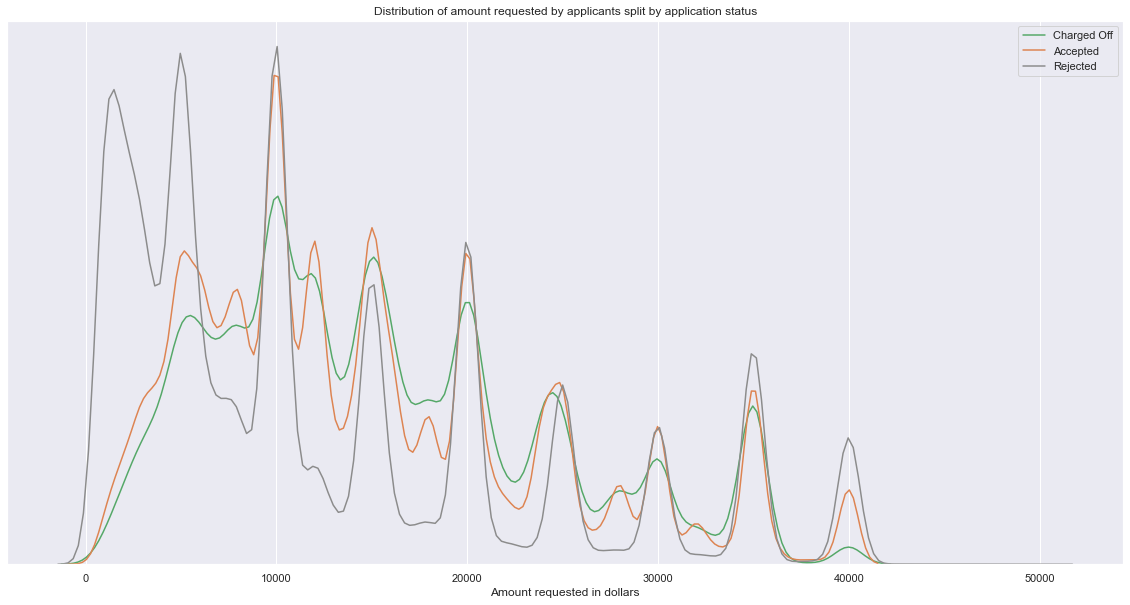

In [18]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df[df["amount_requested"]<50000],
    x="amount_requested",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Amount requested in dollars", ylabel="")
ax.set_title("Distribution of amount requested by applicants split by application status")
ax.set_yticks([])

plt.show()

Since amount_requested feature was so heavily skewed, to better see the differences in distributions for the main body of entries, we have excluded the long tail. There is quite a large difference in distributions from 0 to around 7000 dollars with a lot more rejected applications - seems like investors tend to not be interested in lending such small amounts. There doesn't seem to be much of a difference between accepted and charged off applications.

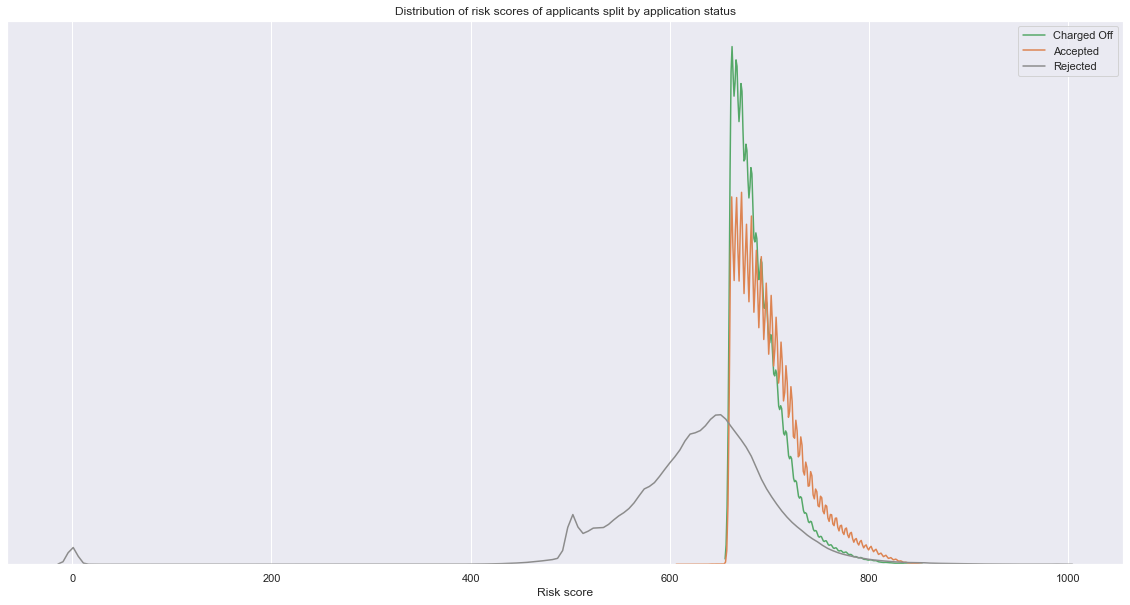

In [20]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="risk_score",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

In [44]:
df.loc[df["accepted"]==1, "risk_score"].sort_values().quantile(0.0001)

647.0

For the risk_score feature we can see that the distributions are quite different. For accepted aplications there are basically no entries under risk score of 647, while the rejected values range from 400 up to over 800. Charged off entries tend to also have a smaller risk score than other accepted entries. Also there seem to be a number of entries with risk score 0 - since 0 is an invalid value for risk score, most likely given to an applicant that hasn't had his risk score measured, we'll have to treat them as missing values.

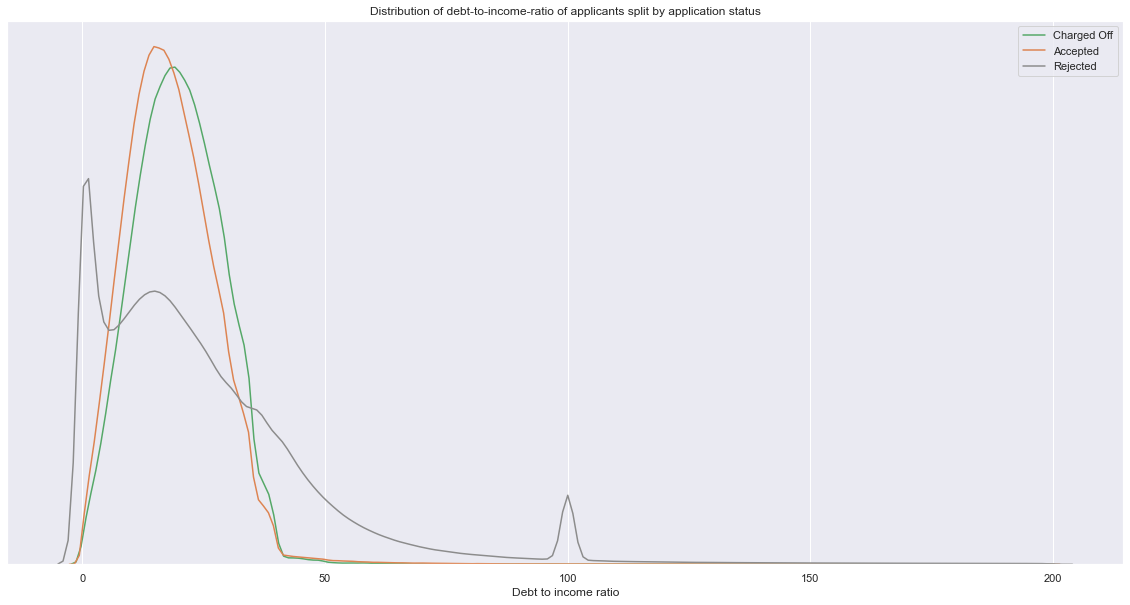

In [21]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df[df["debt_to_income_ratio"]<200],
    x="debt_to_income_ratio",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Debt to income ratio", ylabel="")
ax.set_title("Distribution of debt-to-income-ratio of applicants split by application status")
ax.set_yticks([])

plt.show()

In [49]:
df.loc[df["debt_to_income_ratio"]<0, "debt_to_income_ratio"].value_counts()

-1.0    3810
Name: debt_to_income_ratio, dtype: int64

Debt-to-income-ratio feature was heavily skewed, so, in order to see the difference in distributions, we will again be cutting off the long tail. We can again see quite large differences in distributions for this feature. Applicants that have debt-to-income-ratio of either 0 or above 45 seem a lot less likely to be accepted than the applicants whose debt-to-income-ratio is inbetween. Also, there seem to be some entries with a negative value, which is invalid for this feature - we will be considering those values as missing data.

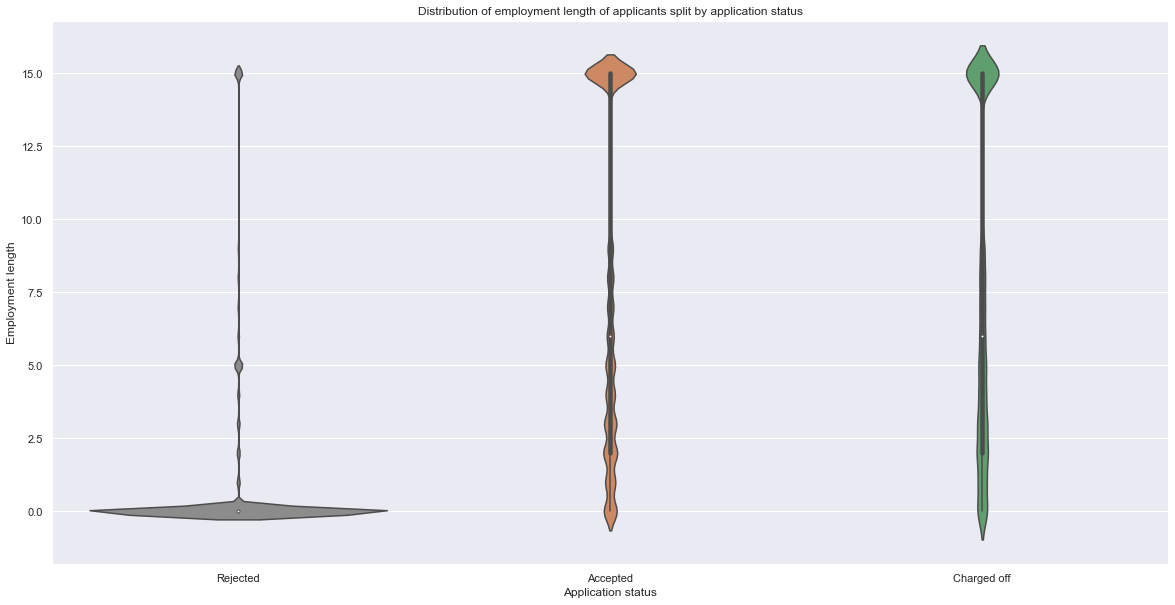

In [53]:
plt.figure(figsize=(20, 10))
ax = sns.violinplot(
    y=df["employment_length_years"],
    x=df["accepted"].replace(accepted_to_words),
    palette=[colors["grey"], colors["orange"], colors["green"]]
)
ax.set(xlabel="Application status", ylabel="Employment length")
ax.set_title("Distribution of employment length of applicants split by application status")

plt.show()

We can see quite extreme differences in distributions for employement_length feature. Almost all of the rejected applicants had worked in their current job for less than a year, while the majority of accepted applicants had worked in their workplace for more than 10 years. 

Next let's take a look at some of the columns containing strings, starting with the loan_title column. We'll count all the different words for entries, split them by status and then check their proportions of total word count per split.

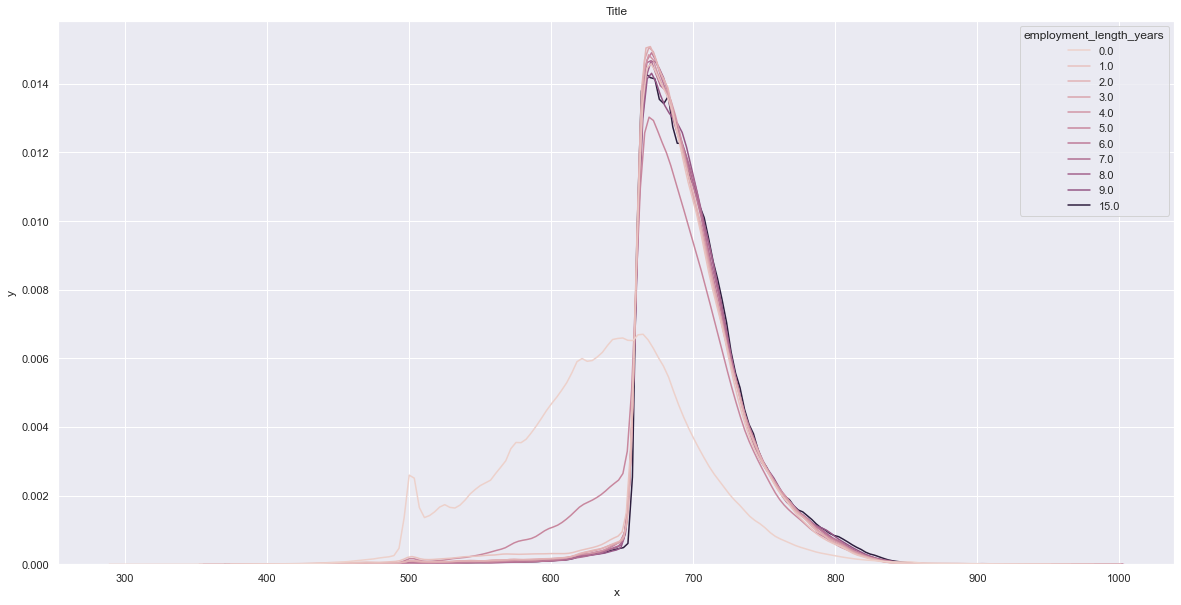

In [103]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=train_set.join(train_accepted),
    x="risk_score",
    hue="employment_length_years",
    common_norm=False
)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Title")

plt.show()

In [54]:
word_df = pd.Series([y for x in df["loan_title"].dropna().values.flatten() for y in x.split()]).value_counts().to_frame("total")
word_df["total"] = (word_df["total"]/word_df["total"].sum()).round(3)
for index, value in enumerate(["rejected", "accepted", "charged_off"]):
    word_df[value] = pd.Series([y for x in df.loc[df["accepted"] == index, "loan_title"].dropna().values.flatten() for y in x.split()]).value_counts()
    word_df[value] = (word_df[value]/word_df[value].sum()).round(3)

difference_words = (word_df[np.abs(word_df["rejected"]-word_df["accepted"]) > 0.01]).index.to_list()

In [55]:
word_df.head(10)

,total,rejected,accepted,charged_off
debt,0.248,0.248,0.244,0.270
consolidation,0.248,0.248,0.244,0.270
credit,0.086,0.068,0.105,0.085
card,0.085,0.067,0.103,0.082
refinancing,0.071,0.040,0.099,0.078
other,0.052,0.082,0.026,0.026
home,0.032,0.031,0.033,0.029
improvement,0.027,0.024,0.030,0.026
car,0.015,0.028,0.005,0.004
purchase,0.012,0.015,0.010,0.009


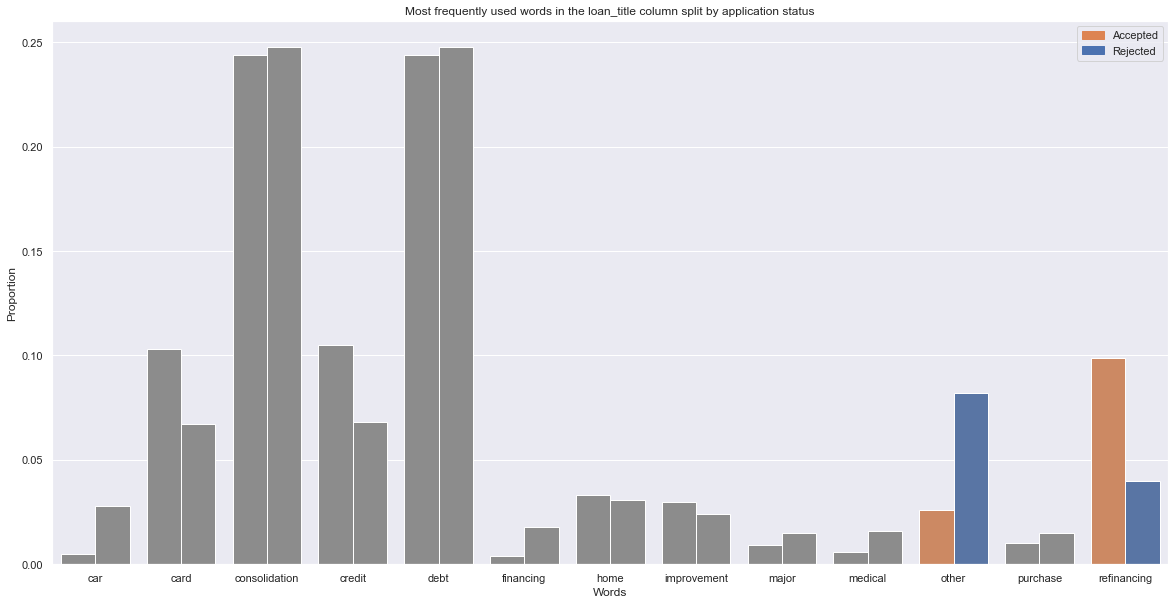

In [56]:
word_df = word_df.loc[word_df["total"] > 0.01, ["rejected", "accepted"]]
word_df = word_df.unstack().reset_index().rename(columns={"level_0":"accepted", "level_1":"word", 0:"count"})
word_df.index.name = "id"

draw_comparison_barplot(word_df, "accepted", "word", ["other", "refinancing"], ["Most frequently used words in the loan_title column split by application status", "Words", "Proportion", "Accepted", "Rejected"], mode="")

We can see that some words are being used in the title a lot more frequently than others - words "debt" and "consolidation" together make up almost half of the total words used. For some words, like "other" and "refinancing", the difference in proportions is quite large and we might use them as features for our model. 

Next we'll look at the zip_code and state columns. 

In [12]:
zip_df = pd.read_csv("data/US_zip_codes_coordinates.txt", sep="\t", header=None)
zip_df = zip_df.drop([0, 2, 3, 5, 6, 7, 8, 11], axis=1)
zip_df.columns = ["zip_code", "state", "latitude", "longitude"]
zip_df = zip_df.dropna(axis=0)

zip_df["bin"] = np.floor(zip_df["zip_code"] / 100).astype(int).astype(str).str.zfill(3) + zip_df["state"]
state_coord_means = zip_df.groupby("state")[["latitude", "longitude"]].mean()
state_coord_means = state_coord_means.rename(columns={"latitude":"state_latitude", "longitude":"state_longitude"})
bin_coord_means = zip_df.groupby("bin")[["latitude", "longitude"]].mean()

zip_df.head()

,zip_code,state,latitude,longitude,bin
0,99553,AK,54.1430,-165.7854,995AK
1,99571,AK,55.1858,-162.7211,995AK
2,99583,AK,54.8542,-163.4113,995AK
3,99612,AK,55.0628,-162.3056,996AK
4,99661,AK,55.3192,-160.4914,996AK


Even though zip code contains numbers, they don't 

In [ ]:
df = zip_state_to_coordinates(df)

df.info()

In [123]:
states = geopandas.read_file("data/maps/tl_2012_us_state.shp")
us_pop_df = pd.read_csv('data/2019_Census_US_Population_Data_By_State_Lat_Long.csv')

states = states.loc[states["STUSPS"].isin(df["state"].unique())]
states.loc[states["NAME"]=="Alaska", "geometry"] = states.loc[states["NAME"]=="Alaska", "geometry"].scale(0.3, 0.3)
states.loc[states["NAME"]=="Alaska", "geometry"] = states.loc[states["NAME"]=="Alaska", "geometry"].translate(-10000000, -3000000)
states.loc[states["NAME"]=="Hawaii", "geometry"] = states.loc[states["NAME"]=="Hawaii", "geometry"].translate(3000000, 1500000)

alaska = states.loc[states["NAME"]=="Alaska", "geometry"]
alaska_geom = alaska[47]
alaska_bool_list = []
for P in alaska_geom.geoms:
    alaska_bool_list.append(P.bounds[0]< -10000000)
alaska = alaska.explode()
alaska = alaska.reset_index().set_index("level_1")
alaska = MultiPolygon(list(alaska[alaska_bool_list].geometry))

states.loc[states["NAME"]=="Alaska", "geometry"] = pd.Series([alaska]).values

loans_states_count = df.groupby("state")["accepted"].count().rename("count")
states = states.merge(loans_states_count, left_on = "STUSPS", right_index=True)
states = states.merge(us_pop_df.set_index("STATE")["POPESTIMATE2019"], left_on = "NAME", right_index=True, how="left")
states["request_proportion"] = states["count"]/states["POPESTIMATE2019"]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_2316\2050284274.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  alaska = alaska.explode()
C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\dtypes\cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


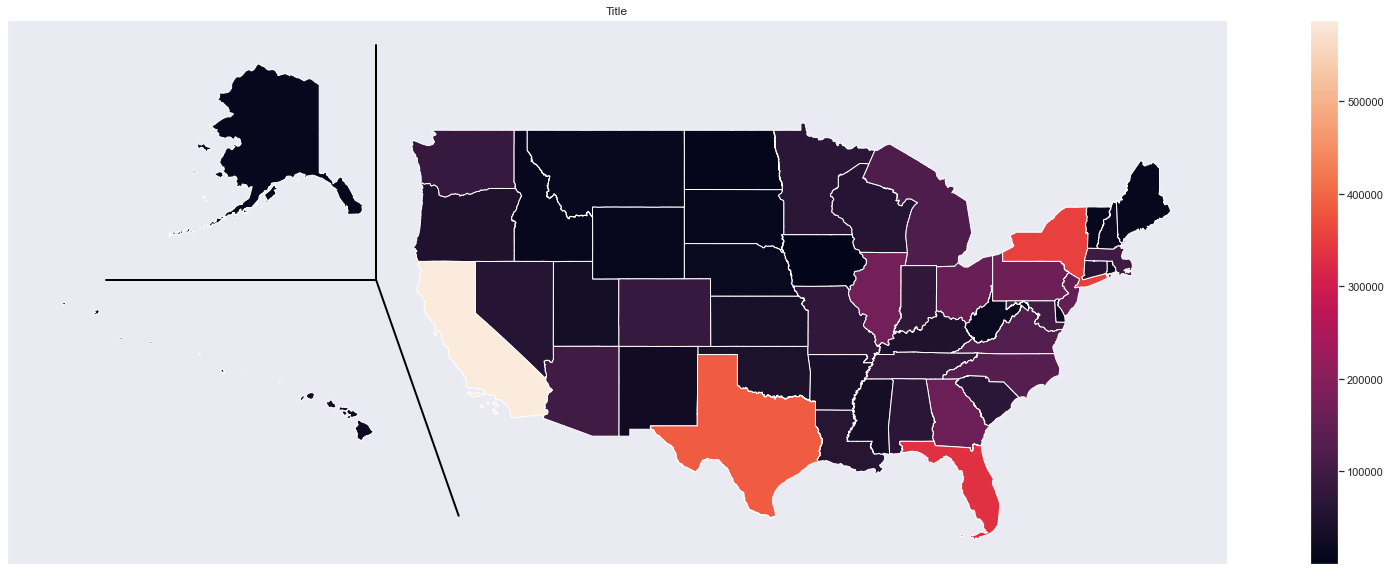

In [155]:
draw_usa(states, "count", "Title")

In [154]:
def draw_usa(df, column, title, legend=True):
    
    ax = df.plot(figsize=(30, 10), column=column, legend=legend)
    ax.plot([-14200000, -14200000], [7000000, 5000000], linewidth=2, color=colors["black"])
    ax.plot([-14200000, -16500000], [5000000, 5000000], linewidth=2, color=colors["black"])
    ax.plot([-14200000, -13500000], [5000000, 3000000], linewidth=2, color=colors["black"])
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

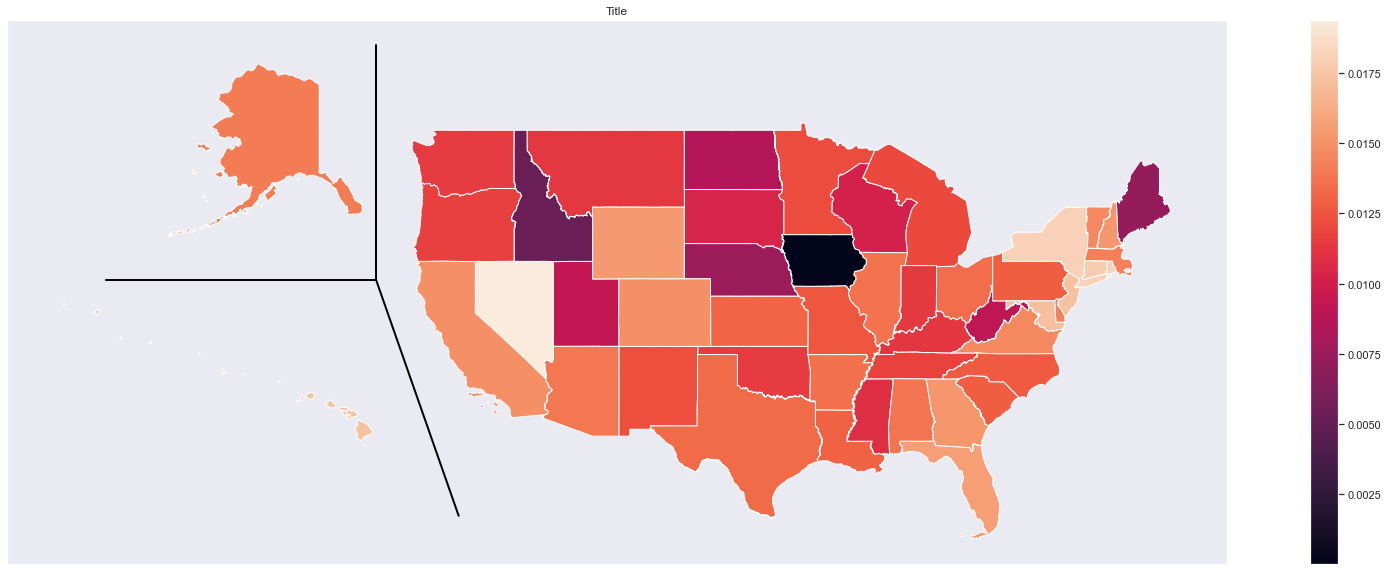

In [156]:
draw_usa(states, "request_proportion", "Title")

In [126]:
ratios_states = df.groupby("state")["accepted"].value_counts().rename("count").to_frame().unstack()
ratios_states.columns = ratios_states.columns.get_level_values(1)
ratios_states["accepted_charged_off_ratio"] = ratios_states[2]/(ratios_states[1]+ratios_states[2])
ratios_states["accepted_rejected_ratio"] = ratios_states[0]/(ratios_states[1]+ratios_states[2])
ratios_states = ratios_states.drop([0, 1, 2], axis=1)

states = states.merge(ratios_states, left_on = "STUSPS", right_index=True, how="left")

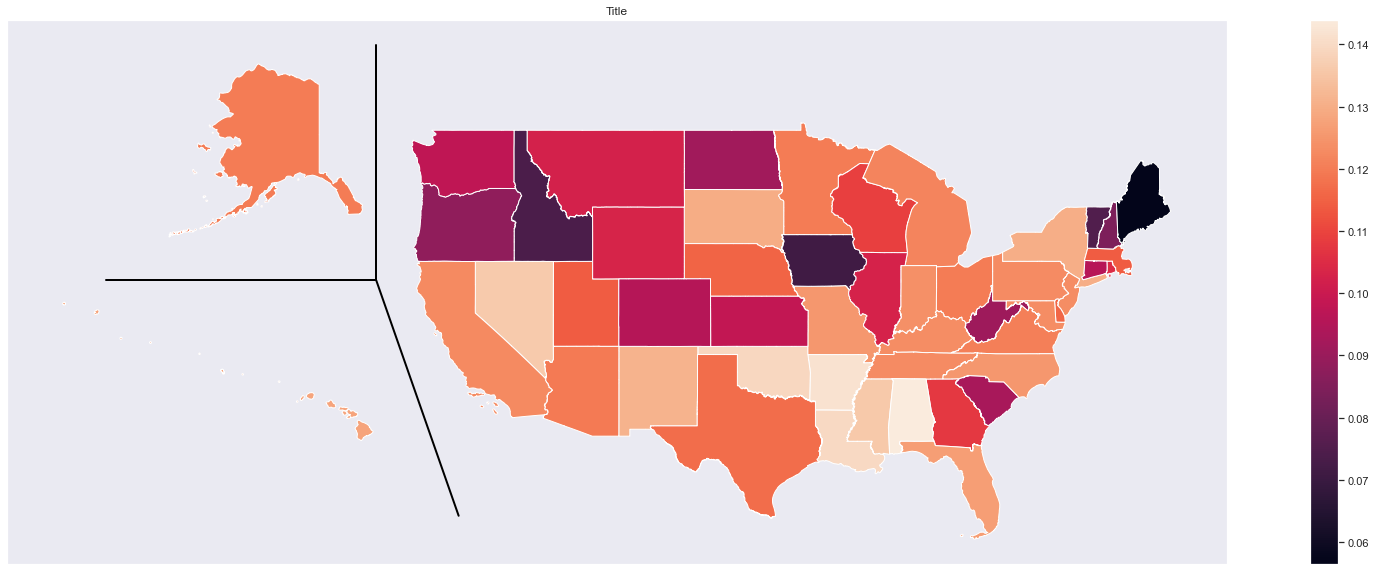

In [157]:
draw_usa(states, "accepted_charged_off_ratio", "Title")

In [142]:
states.loc[states["accepted_charged_off_ratio"].sort_values()[:5].index].loc[:, ["NAME", "count", "accepted_charged_off_ratio"]]

,NAME,count,accepted_charged_off_ratio
35,Maine,9744,0.056494
37,Iowa,98,0.071429
11,Idaho,9375,0.073816
27,Vermont,9094,0.074944
34,New Hampshire,20598,0.084365


In [143]:
states.loc[states["accepted_charged_off_ratio"].sort_values(ascending=False)[:5].index].loc[:, ["NAME", "count", "accepted_charged_off_ratio"]]

,NAME,count,accepted_charged_off_ratio
31,Alabama,67508,0.143899
1,Arkansas,41034,0.141736
17,Louisiana,60311,0.139485
14,Oklahoma,45303,0.139336
54,Nevada,59678,0.136050


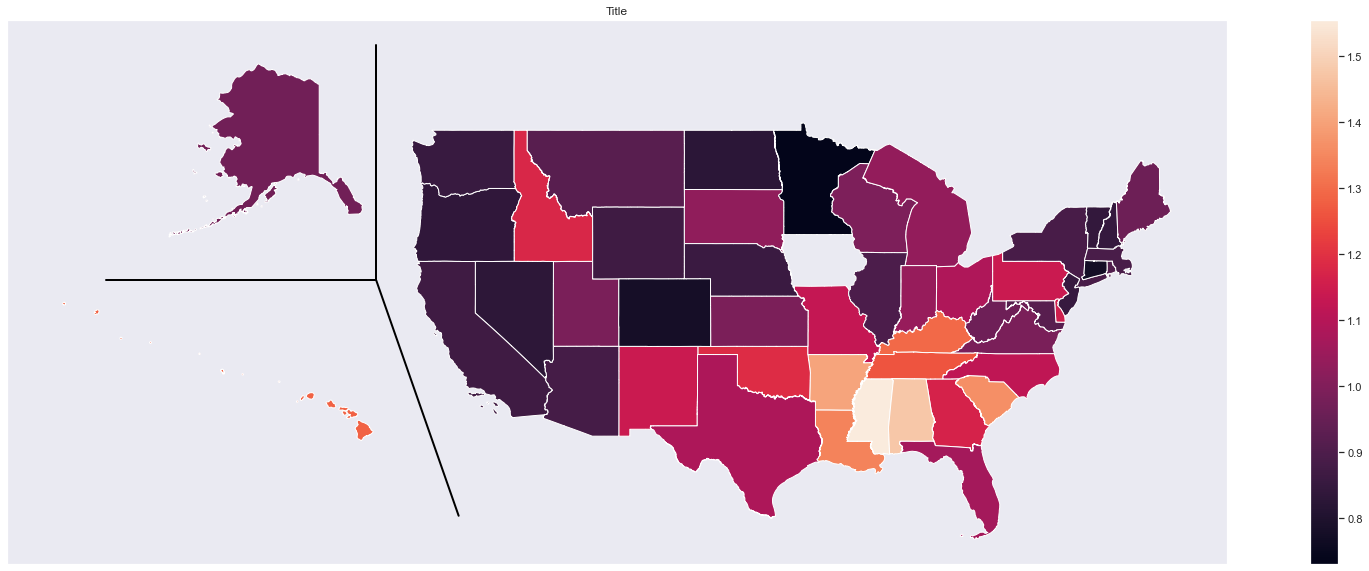

In [158]:
draw_usa(states[states["NAME"]!="Iowa"], "accepted_rejected_ratio", "Title")

In [4]:
class ZipStateToCoordinates(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, state_coord_means, bin_coord_means, state=True):
        self.state_coord_means = state_coord_means
        self.bin_coord_means = bin_coord_means
        self.state = state

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        
        if self.state:
            X1 = X1.drop(X1[X1["state"].isnull()].index.tolist(), axis=0)
            X1 = X1.reset_index().merge(state_coord_means.reset_index(), on="state", how="left").set_index("index")
            X1 = X1.drop(["zip_code", "state"], axis=1)
            X1.rename(columns={"state_latitude":"latitude", "state_longitude":"longitude"})
            
        else:
            X1 = X1.drop(X1[X1["zip_code"].isnull()].index.tolist(), axis=0)
            X1["bin"] = X1["zip_code"].str.strip("x") + X1["state"]
            X1 = X1.merge(self.bin_coord_means.reset_index(), on="bin", how="left")
            X1 = X1.merge(self.state_coord_means.reset_index(), on="state", how="left")
            X1["latitude"] = X1["latitude"].fillna(X1["state_latitude"])
            X1["longitude"] = X1["longitude"].fillna(X1["state_longitude"])
            X1 = X1.drop(["zip_code", "bin", "state", "state_latitude", "state_longitude"], axis=1)
            
        return X1

In [5]:
class ExtractWords(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, difference_words):
        self.difference_words = difference_words

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        for word in self.difference_words:
            current_word = f'word_{word}'
            X1.loc[X1["loan_title"].str.contains(fr"(?:^|\W){word}(?:$|\W)").fillna(False), current_word] = 1
            X1.loc[:, current_word] = X1.loc[:, current_word].fillna(0).astype(int)
        X1 = X1.drop("loan_title", axis=1)
        return X1

In [6]:
class AddMissingColumn(BaseEstimator, TransformerMixin):
    """
    Transformer that adds a "missing_data" column to the dataset, populated with binary values.
    Positive value is given if any of the features has a missing value in the row, with a
    dictionary passed as an argument with {feature:value} pairs that show the missing
    value for the feature.
    """
    def __init__(self, missing_dict, one_column=True):
        self.missing_list = list(missing_dict.keys())
        self.one_column = one_column

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        if self.one_column:
            for elem in self.missing_list:
                X1.loc[X1[elem].isna(), "missing_data"] = 1
            X1["missing_data"] = X1["missing_data"].fillna(0)
            
        else:
            for elem in self.missing_list:
                X1.loc[X1[elem].isna(), f"{elem}_missing"] = 1
            missing_columns = X1.columns[X1.columns.str.contains("_missing")]
            X1.loc[:,missing_columns] = X1.loc[:,missing_columns].fillna(0)
            
        return X1

In [7]:
class UnknownToNan(BaseEstimator, TransformerMixin):
    """
    Transformer that changes a differently marked missing value to np.nan.
    """
    def __init__(self, missing_dict):
        self.missing_dict = missing_dict

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        for key in self.missing_dict:
            if self.missing_dict[key] == "nan":
                continue
            else:
                X1.loc[X1[key] == self.missing_dict[key], key] = np.nan
        
        return X1


In [71]:
train_set.median()

amount_requested            10000.000000
risk_score                    673.000000
debt_to_income_ratio           18.660000
employment_length_years         0.000000
word_refinancing                0.000000
word_other                      0.000000
word_car                        0.000000
word_medical                    0.000000
word_moving                     0.000000
state_latitude                 37.714359
state_longitude               -86.267456
missing_data                    0.000000
debt_to_income_ratio_log        2.926382
dtype: float64

In [ ]:
class FillMissingData(BaseEstimator, TransformerMixin):
    """
    Transformer that changes a differently marked missing value to np.nan.
    """
    def __init__(self):

    def fit(self, X: pd.DataFrame, y=None):
        self.risk_score_employement_means = X.groupby("employment_length_years")["risk_score"].mean()
        self.column_means = X.median()
        return self

    def transform(self, X: pd.DataFrame):
        X1 = X.copy()
        X1["
        return X1


In [72]:
risk_score_employement_means = train_set.groupby("employment_length_years")["risk_score"].mean()
risk_score_employement_means

employment_length_years
0.0     635.484802
1.0     693.846558
2.0     696.927856
3.0     697.435364
4.0     698.209656
5.0     688.843140
6.0     699.139404
7.0     699.619751
8.0     699.736816
9.0     699.926025
15.0    701.181763
Name: risk_score, dtype: float32

In [ ]:
train_set.merge(risk_score_employement_means.rename("risk_score_mean", )

In [73]:
train_set["employment_length_years"].value_counts()

0.0     1767820
15.0     574564
2.0      159307
5.0      143737
3.0      140815
1.0      119397
4.0      106387
6.0       79265
7.0       70766
8.0       69534
9.0       59909
Name: employment_length_years, dtype: int64

In [115]:
((train_set["risk_score"] == 0).sum()/train_set.shape[0]*100).round(2)

0.5

In [13]:
#TODO: Delete before submitting
df = clean_data(df)

## Missing data and data engineering

In [15]:
df = df_copy
del(df_copy)
df

,amount_requested,loan_title,risk_score,debt_to_income_ratio,zip_code,state,employment_length_years,accepted
0,5000,medical expenses,516.0,34.419998,371xx,TN,0.0,0
1,18000,credit card refinancing,768.0,75.209999,360xx,AL,0.0,0
2,6000,crush my high aprs,772.0,4.030000,982xx,WA,5.0,0
3,19000,other,656.0,31.379999,381xx,TN,0.0,0
4,6000,business,613.0,35.180000,309xx,GA,0.0,0
...,...,...,...,...,...,...,...,...
4508712,24000,home improvement,667.0,19.610001,356xx,AL,7.0,1
4508713,24000,debt consolidation,697.0,34.939999,840xx,UT,15.0,1
4508714,40000,NaN,707.0,12.750000,907xx,CA,9.0,1
4508715,24000,debt consolidation,662.0,18.299999,334xx,FL,6.0,2


In [15]:
df["accepted"].value_counts()

0    2248049
1    1992109
2     268559
Name: accepted, dtype: int64

In [16]:
df = df[df["accepted"]!=2]

In [60]:
train_set, test_set, train_accepted, test_accepted = train_test_split(
    df.loc[:, df.columns[df.columns != "accepted"]],
    df["accepted"],
    test_size=0.2,
    random_state=42,
    stratify=df["accepted"]
)

In [ ]:




#TODO : Create a default model to benchmark - without data engineering





In [18]:
def get_relevant_words(df, target):
    word_df = pd.Series([y for x in df["loan_title"].dropna().values.flatten() for y in x.split()]).value_counts().to_frame("total")
    word_df["total"] = (word_df["total"]/word_df["total"].sum()).round(3)
    for index, value in enumerate(["rejected", "accepted"]):
        word_df[value] = pd.Series([y for x in df.loc[target == index, "loan_title"].dropna().values.flatten() for y in x.split()]).value_counts()
        word_df[value] = (word_df[value]/word_df[value].sum()).round(3)

    difference_words = (word_df[np.abs(word_df["rejected"]-word_df["accepted"]) > 0.01]).index.to_list()

    word_df = pd.DataFrame(index=df.index)
    for word in difference_words:
        word_df.loc[df["loan_title"].str.contains(fr"(?:^|\W){word}(?:$|\W)").fillna(False), word] = 1
        word_df.loc[:, word] = word_df.loc[:, word].fillna(0).astype(int)

        word_corr = word_df.corrwith(word_df[word])
        multicoll_list = word_corr[(word_corr > 0.7) & (word_corr.index != word)].index.tolist()
        if multicoll_list:
            for multicoll_name in multicoll_list:
                if np.abs(word_df[multicoll_name].corr(target)) < np.abs(word_df[word].corr(target)):
                    word_df = word_df.drop(multicoll_name, axis=1)
                else:
                    word_df = word_df.drop(word, axis=1)
                    break
    return word_df.columns.to_list()

relevant_words = get_relevant_words(train_set, train_accepted)

In [23]:
train_set.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,amount_requested,risk_score,debt_to_income_ratio,employment_length_years
count,3392126.000,3392126.000,3390813.000,3291501.000
mean,13732.891,662.396,99.688,3.855
std,10204.377,78.984,5529.679,5.602
min,400.000,0.000,-1.000,0.000
25%,5000.000,632.000,10.680,0.000
50%,10000.000,672.000,18.640,0.000
75%,20000.000,702.000,28.670,6.000
max,250000.000,990.000,4408800.000,15.000


In [46]:
missing_dict = {"debt_to_income_ratio":-1, "risk_score":0}

In [61]:
preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(missing_dict, one_column = True)),
    ]
)

train_set = preprocessor.fit_transform(train_set)
train_set

,amount_requested,risk_score,debt_to_income_ratio,employment_length_years,word_refinancing,word_other,word_car,word_medical,word_moving,state_latitude,state_longitude,missing_data
index,,,,,,,,,,,,
262519,2500,529.0,5.150000,0.0,0,0,0,0,0,39.054236,-76.781127,0.0
1460895,40000,676.0,19.549999,0.0,0,0,0,0,0,42.235578,-71.494764,0.0
3893054,8500,727.0,13.630000,8.0,0,0,0,0,0,40.385115,-74.516701,0.0
3446293,10000,677.0,26.590000,6.0,0,0,0,0,0,28.127902,-81.955584,0.0
3371203,10000,752.0,17.010000,4.0,0,0,0,0,0,39.263851,-105.317230,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
990374,30000,627.0,31.740000,0.0,0,0,0,0,0,31.274343,-97.997900,0.0
3747235,36000,727.0,0.940000,4.0,0,0,0,0,0,40.619828,-77.561899,0.0
2504831,17000,662.0,18.830000,3.0,1,0,0,0,0,37.714359,-78.231150,0.0


In [54]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3392126 entries, 262519 to 252772
Data columns (total 12 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amount_requested         int32  
 1   risk_score               float32
 2   debt_to_income_ratio     float32
 3   employment_length_years  float32
 4   word_refinancing         int32  
 5   word_other               int32  
 6   word_car                 int32  
 7   word_medical             int32  
 8   word_moving              int32  
 9   state_latitude           float64
 10  state_longitude          float64
 11  missing_data             float64
dtypes: float32(3), float64(3), int32(6)
memory usage: 220.0 MB


In [53]:
train_set.isnull().sum()

amount_requested                0
risk_score                  17516
debt_to_income_ratio         4387
employment_length_years    100625
word_refinancing                0
word_other                      0
word_car                        0
word_medical                    0
word_moving                     0
state_latitude                  0
state_longitude                 0
missing_data                    0
dtype: int64

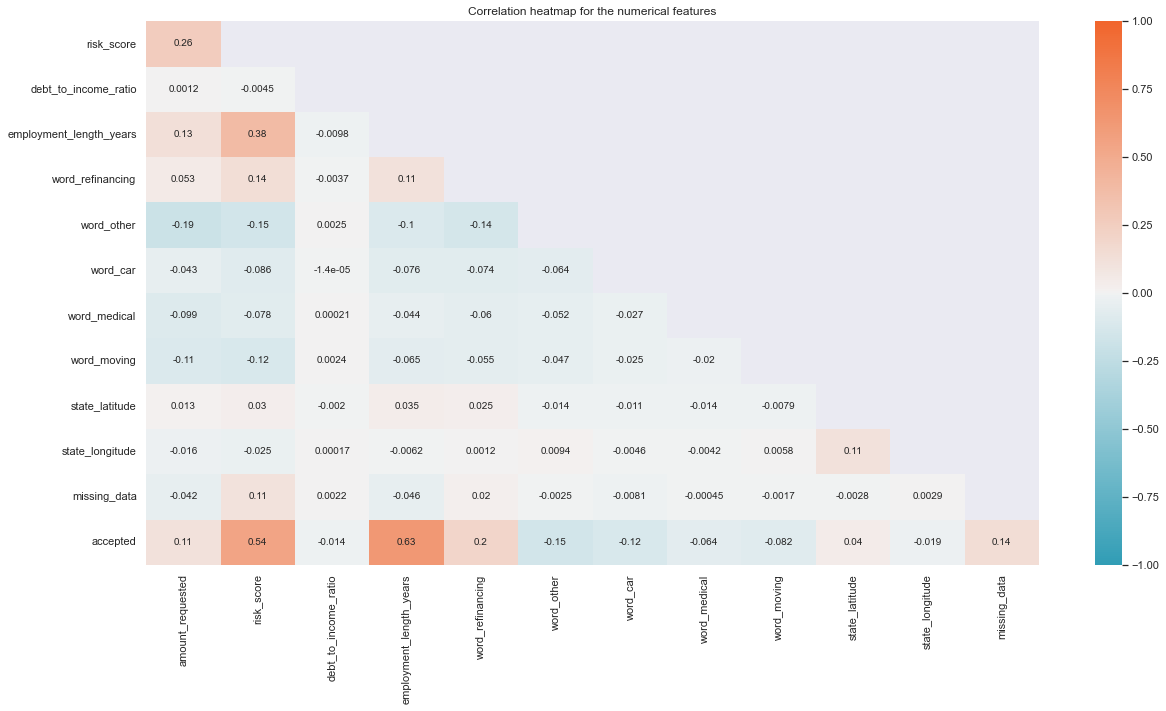

In [55]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(train_set.join(train_accepted).corr(), dtype=bool))
mask = mask[1:, :-1]
corr = train_set.join(train_accepted).corr().iloc[1:, :-1].copy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin=-1, vmax=1)
ax.set_title("Correlation heatmap for the numerical features")
plt.show()

In [64]:
len(train_set.loc[train_set["employment_length_years"].isna() & train_set["risk_score"].isna()])

0

In [91]:
train_set.groupby("employment_length_years")["risk_score"].mean()

employment_length_years
0.0     629.851196
1.0     692.005371
2.0     695.772278
3.0     696.698730
4.0     697.252380
5.0     688.215088
6.0     698.583130
7.0     699.000244
8.0     699.400940
9.0     699.647278
15.0    700.991516
Name: risk_score, dtype: float32

In [68]:
train_set["debt_to_income_ratio"].mean()

99.77967

In [69]:
train_set["debt_to_income_ratio"].median()

18.66

In [65]:
train_set["debt_to_income_ratio_log"] = np.log(train_set["debt_to_income_ratio"])

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


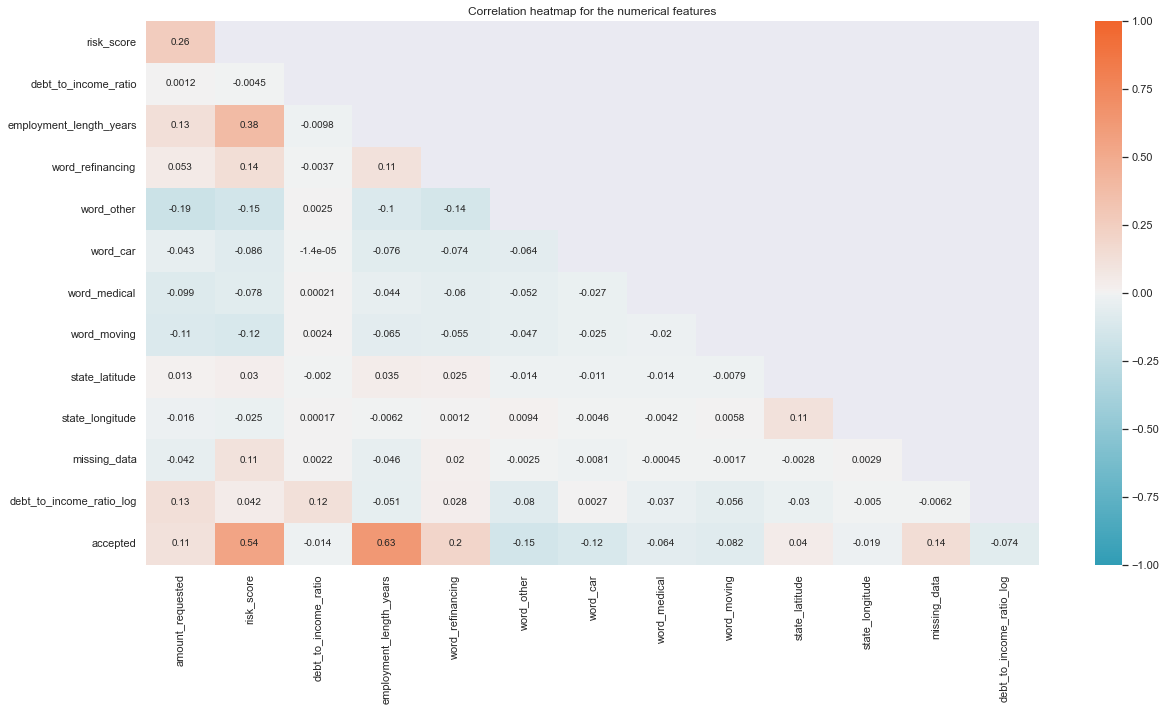

In [66]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(train_set.join(train_accepted).corr(), dtype=bool))
mask = mask[1:, :-1]
corr = train_set.join(train_accepted).corr().iloc[1:, :-1].copy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin=-1, vmax=1)
ax.set_title("Correlation heatmap for the numerical features")
plt.show()

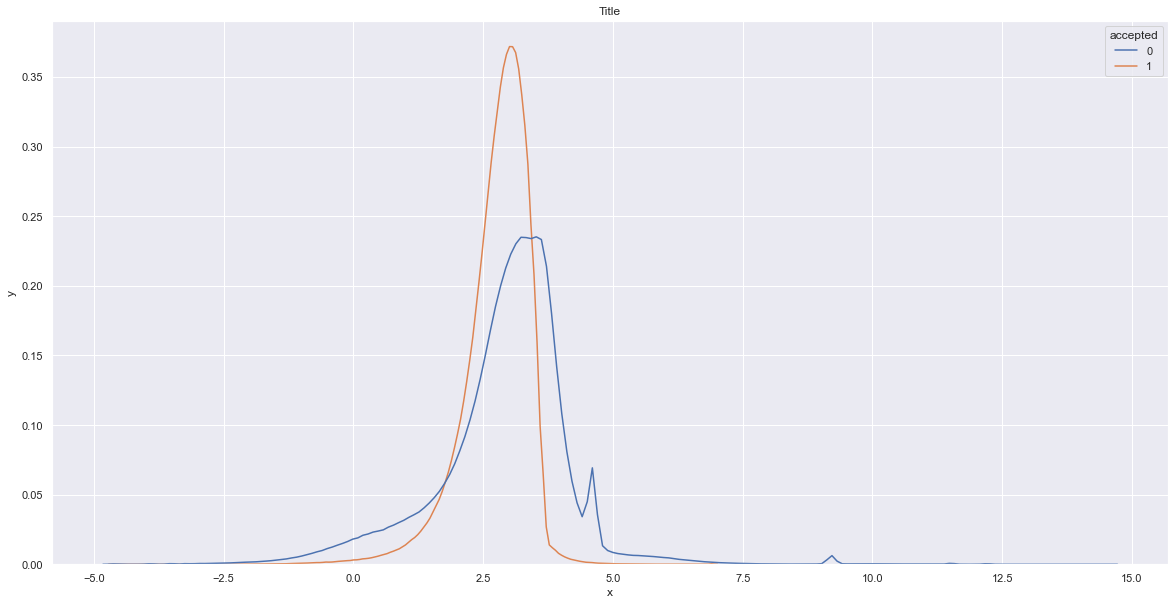

In [144]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=train_set.join(train_accepted),
    x="debt_to_income_ratio_log",
    hue="accepted"
)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Title")

plt.show()

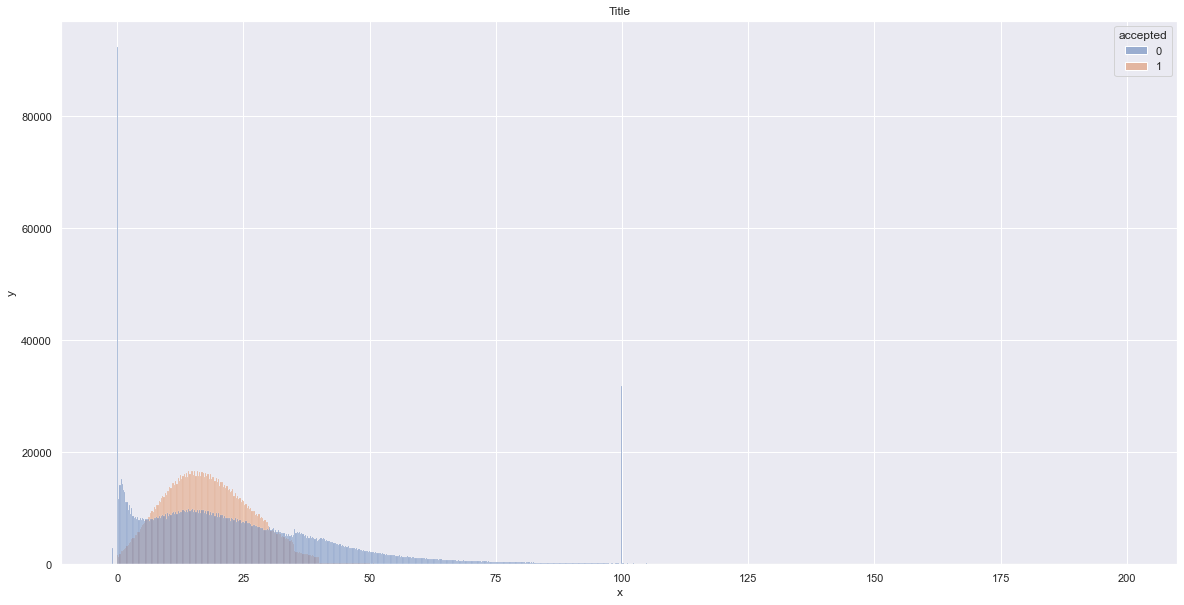

In [146]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(
    data=(train_set[train_set["debt_to_income_ratio"]<200]).join(train_accepted),
    x="debt_to_income_ratio",
    hue="accepted"
)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Title")

plt.show()

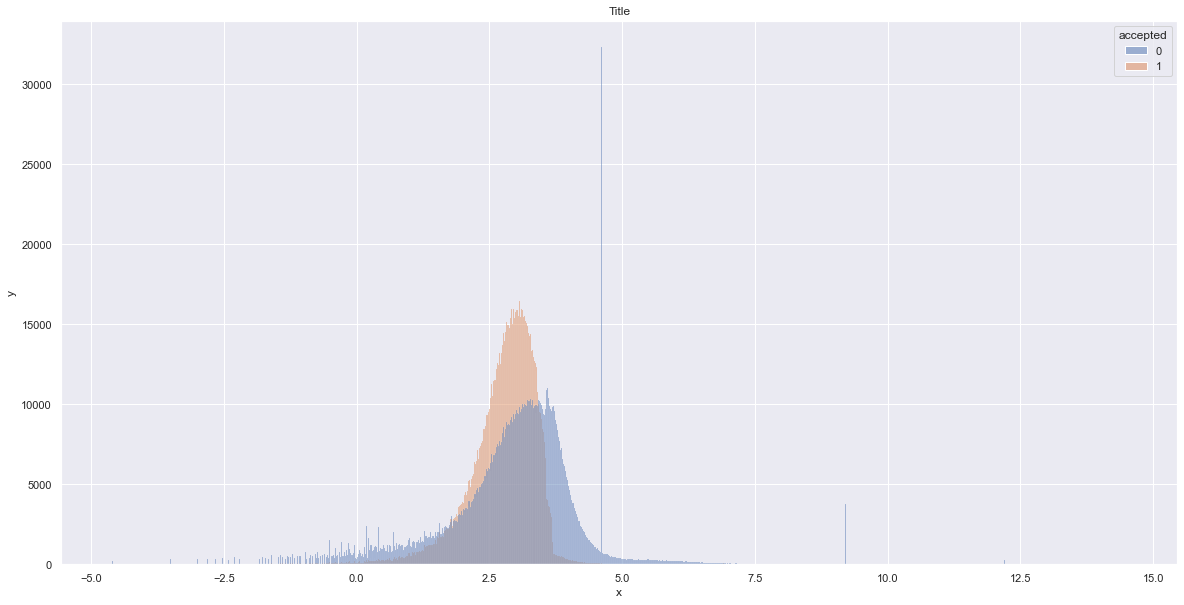

In [145]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(
    data=train_set.join(train_accepted),
    x="debt_to_income_ratio_log",
    hue="accepted"
)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Title")

plt.show()

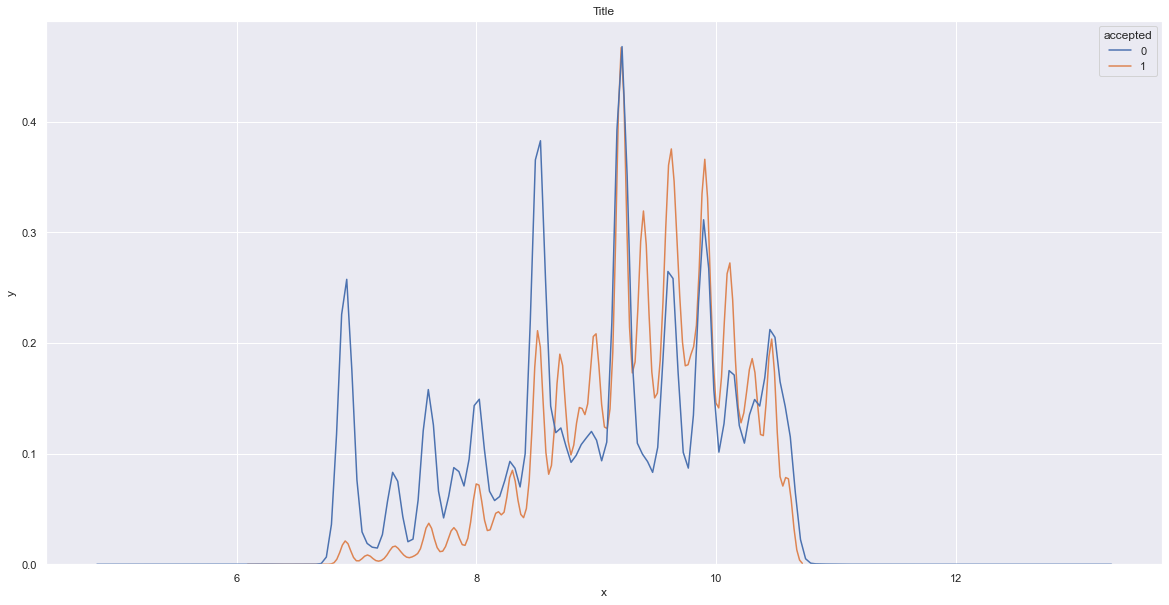

In [153]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=train_set.join(train_accepted),
    x="amount_requested_log",
    hue="accepted"
)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Title")

plt.show()

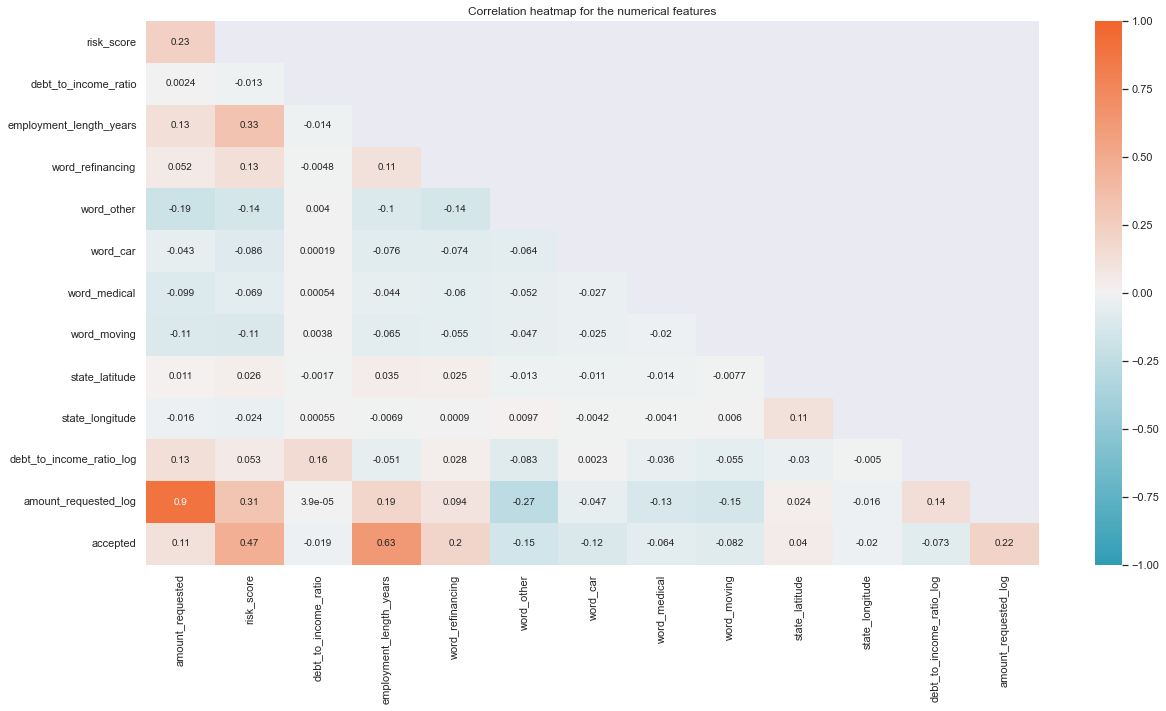

In [154]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(train_set.join(train_accepted).corr(), dtype=bool))
mask = mask[1:, :-1]
corr = train_set.join(train_accepted).corr().iloc[1:, :-1].copy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin=-1, vmax=1)
ax.set_title("Correlation heatmap for the numerical features")
plt.show()

In [ ]:
train_set.join(train_accepted)

In [149]:
train_set["debt_to_income_ratio"][train_set["debt_to_income_ratio"]<0].unique()

array([-1.], dtype=float32)

In [151]:
train_set["amount_requested_log"] = np.log(train_set["amount_requested"])

In [134]:
train_set["debt_to_income_ratio_log"] = np.log(train_set["debt_to_income_ratio"])

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [135]:
train_set["debt_to_income_ratio_log"]

,amount_requested,risk_score,debt_to_income_ratio,employment_length_years,word_refinancing,word_other,word_car,word_medical,word_moving,state_latitude,state_longitude,debt_to_income_ratio_log
index,,,,,,,,,,,,
262519,5000,736.0,36.480000,0.0,0,0,0,0,0,28.127902,-81.955584,3.596764
1460895,25000,663.0,22.840000,0.0,0,1,0,0,0,43.443537,-84.735604,3.128513
3893054,8500,727.0,13.630000,8.0,0,0,0,0,0,40.385115,-74.516701,2.612273
3446293,10000,677.0,26.590000,6.0,0,0,0,0,0,28.127902,-81.955584,3.280535
3371203,10000,752.0,17.010000,4.0,0,0,0,0,0,39.263851,-105.317230,2.833802
...,...,...,...,...,...,...,...,...,...,...,...,...
990374,1700,682.0,22.870001,5.0,0,0,0,0,0,35.573569,-79.528286,3.129826
3747235,36000,727.0,0.940000,4.0,0,0,0,0,0,40.619828,-77.561899,-0.061875
2504831,17000,662.0,18.830000,3.0,1,0,0,0,0,37.714359,-78.231150,2.935451


In [129]:
np.log(pd.Series(0))

0   -inf
dtype: float64

In [133]:
np.log(train_set["debt_to_income_ratio"]).isnull().sum()

SyntaxError: unexpected EOF while parsing (611653037.py, line 1)

In [132]:
np.log(train_set["debt_to_income_ratio"])[np.log(train_set["debt_to_income_ratio"])< -1]

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


index
1218186        -inf
2050991        -inf
361142         -inf
1783874        -inf
361026         -inf
             ...   
209093         -inf
1100699        -inf
497563         -inf
1372633   -1.771957
412135         -inf
Name: debt_to_income_ratio, Length: 104144, dtype: float32

In [123]:
train_set["debt_to_income_ratio"]

index
262519     36.480000
1460895    22.840000
3893054    13.630000
3446293    26.590000
3371203    17.010000
             ...    
990374     22.870001
3747235     0.940000
2504831    18.830000
1925627    28.920000
252772     26.570000
Name: debt_to_income_ratio, Length: 3392126, dtype: float32